## Installing Libraries

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ultralytics

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\aswan\\anaconda3\\envs\\college_project\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --user albumentations

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [5]:
import torch
import torch.cuda

import os
from PIL import Image, ImageDraw, ImageFont
import cv2
import random
import shutil
import numpy as np
from pathlib import Path
import albumentations as A
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re
from collections import Counter

C:\Users\aswan\AppData\Roaming\Python\Python39\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Testing CUDA (GPU)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [8]:
torch.cuda.device_count()

1

## Datasets Description

- CAUCAFALL
  
CAUCAFall is a database created with the aim of recognizing human falls, where its differential feature lies in the fact that it is  created in conditions of an uncontrolled home environment, with occlusions, changes in lighting (natural, artificial, and night), variety in the clothing of the participants, movement in the background, different textures on the floor and room, variety in the angles of fall, different distances from the camera to the fall, with participants of different age, weight, height, and even different dominant leg, which contributes to the real progress of research in the recognition of falls. In addition, the proposed database is the only one that contains segmentation labels in each of its images, which serve to be able to implement human fall recognition methods by means of YOLO detectors.

Subjects simulated 5 types of falls and 5 types of activities of daily living (ADLs). The data included forward falls, backward falls, falls to the left, falls to the right, and falls arising from sitting. The ADLs performed by the participants are: walking, hopping, picking up an object, sitting, and finally kneeling. Frames that recorded human falls were labeled as "fall" and ADLs were labeled as "no-fall".

The data are organized into 10 main directories corresponding to the subjects, each of which contains 10 folders with the different activities performed by the participants, and in each folder there is a video of the action in .avi format, the images of the actions in .png format, and each of the frame segmentation labels in .txt format.

- LE2I AUGMENTED

The LE2I dataset is designed for human activity recognition and is sourced from the Roboflow platform. It contains a collection of images and annotations aimed at detecting various human activities in both controlled and real-world settings. The dataset is already augmented to increase the diversity and variety of the data, ensuring that the models trained on it can generalize better in real-world applications. The dataset features images with a wide range of activities, from everyday actions like walking, sitting, and standing. But the augmentation contains falls only. This augmentation includes variations in lighting, background noise, pose, and occlusion to enhance the robustness of machine learning models.

The LE2I dataset is organized into directories with corresponding activity labels, which include both images and their associated segmentation masks. Only training set is used for training the model.

- HUMANPOSE

The HumanPose dataset, sourced from Roboflow, is a comprehensive collection designed for human pose estimation and fall detection tasks. It combines data from various publicly available datasets, providing a diverse range of scenarios such as office, lab, and home environments. The dataset includes both single-person and multi-person frames, with annotations for human poses and fall events. It contains instances of both single falls and multiple falls within the same frame, making it ideal for training models to recognize and track human movements, as well as detect falls in various real-world contexts. The varied environments and scenarios offer a robust foundation for developing accurate and adaptable models for human behavior analysis.

  

Here’s a summary of the structure and organization of the datasets.

### **CAUCAFall Dataset:**
- **Total Folders:** 10 main folders, each corresponding to a subject.
- **Inside Each Folder:**
  - **10 Activities**:
    1. Forward fall
    2. Backward fall
    3. Fall to the left
    4. Fall to the right
    5. Fall from sitting
    6. Walking
    7. Hopping
    8. Picking up an object
    9. Sitting
    10. Kneeling
  - **Fall and Non-Fall Frames:**
    - Falls are labeled as "fall."
    - Activities of daily living (ADLs) are labeled as "no-fall" (with ADLs having annotation value 0, so no extra work needed).
  - **Required Folder Structure:**
    - Images: Store all images.
    - Labels: Store all corresponding annotation files.
    - Inside each folder: Split into **train**, **test**, and **val** folders for both images and labels.

### **HumanPose Dataset:**
- **Already Organized Structure:**
  - The dataset already has the structure of **images** and **labels** inside folders divided into **train**, **test**, and **val**.
  - No additional folder organization or work needed.

### **LE2I Dataset:**
- **Folder Structure:**
  - Only the **train** folder is used for both **images** and **labels**.
  - As the images are only falls, the augmentation **falls** mentioned 0 instead of 1. So 0 to 1 conversion needed
  - No additional folder organization needed as it is used solely for training.

## Dataset folder structuring


- **CAUCAFall Dataset Folder Structuring:**
  - An external notebook was used to structure the CAUCAFall folder organization.
  - The images were first moved into **fall** and **non-fall** directories from each of the 10 subject folders.
  - This step ensures that the **train**, **test**, and **val** sets contain both fall and non-fall images.
  - Afterward, the images were reorganized into the **YOLO** folder structure.

  **Link to the file:** College Project/caucafall_dataset_structuring.ipynb

- **LE2I Dataset Augmentation:**
  - An external Python file was used to convert all annotation values of **0** to **1** in the augmented files.

  **Link to the file:** College Project/invert_falls_label.py



## Plotting few image with bounding box

In [10]:
# function to visualize image with draw bounding box
def draw_bbox(image_path, annotation_path):
    # Load image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    
    # Read annotation
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert YOLO format (normalized) to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Define color and label
        if class_id == 1:  # fall
            color = (0, 0, 255)  # Red
            label = "FALL"
        else:  # non-fall
            color = (0, 255, 0)  # Green
            label = "NON-FALL"

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Convert BGR image to RGB (for matplotlib display)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image in Jupyter notebook
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()



### Caucafall

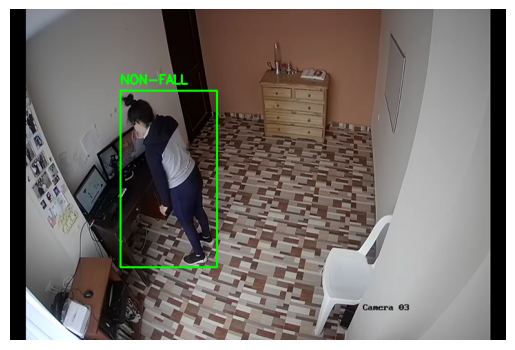

In [22]:
# non fall image
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\cas100002.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\cas100002.txt"

draw_bbox(image_path, annotation_path)


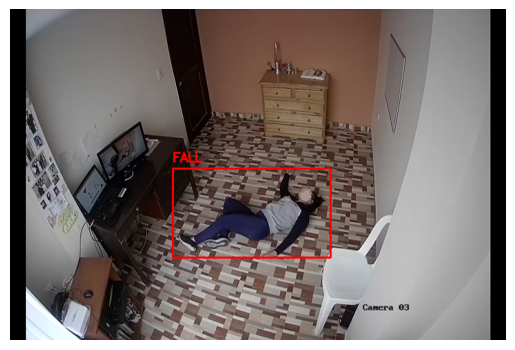

In [23]:
# fall image
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\cas100096.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\cas100096.txt"

draw_bbox(image_path, annotation_path)

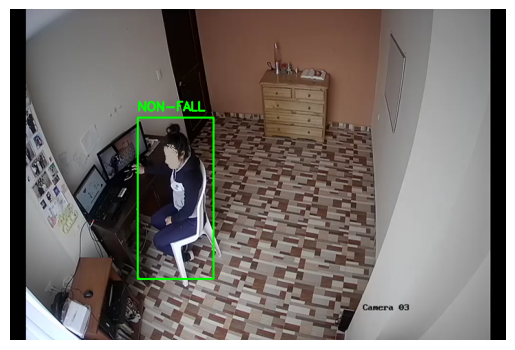

In [24]:
# non fall image (kneeling position)
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\ses100139.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\ses100139.txt"

draw_bbox(image_path, annotation_path)


### Le2i

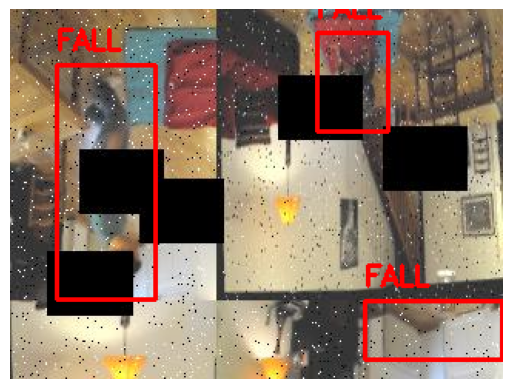

In [14]:
# annotated image with fall only
image_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\images\train\000004_jpg.rf.fe76f4b52088d3ef1c10f747de076fbf.jpg"
annotation_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\labels\train\000004_jpg.rf.fe76f4b52088d3ef1c10f747de076fbf.txt"

draw_bbox(image_path, annotation_path)


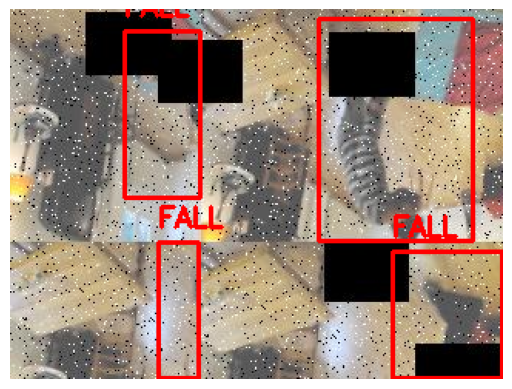

In [15]:
# annotated image with fall only
image_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\images\train\000152_jpg.rf.f2f5438481ff955eb997563a009623a9.jpg"
annotation_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\labels\train\000152_jpg.rf.f2f5438481ff955eb997563a009623a9.txt"

draw_bbox(image_path, annotation_path)


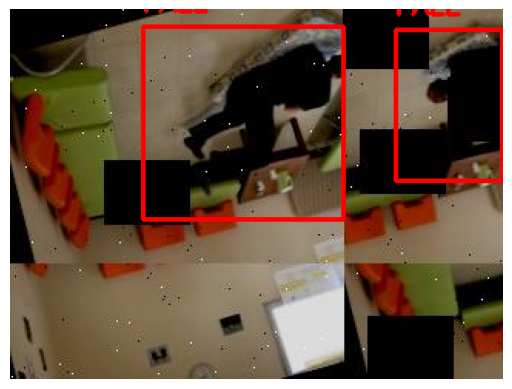

In [16]:
# annotated image with fall only
image_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\images\train\001560_jpg.rf.854446ac9521a4508d4bf2e606d18c56.jpg"
annotation_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset\labels\train\001560_jpg.rf.854446ac9521a4508d4bf2e606d18c56.txt"

draw_bbox(image_path, annotation_path)


### Humanpose

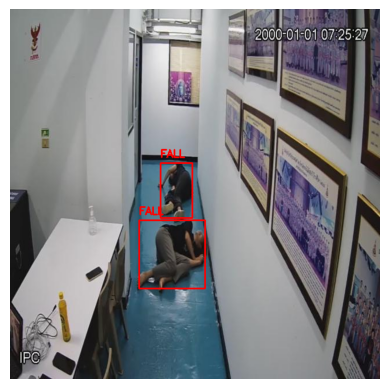

In [17]:
# annotated image with two person fall
image_path = r"C:\Users\aswan\College Project\Humanpose dataset\images\train\0_jpg.rf.19bfac5bf55411a6cfa96c204a3809d0.jpg"
annotation_path = r"C:\Users\aswan\College Project\Humanpose dataset\labels\train\0_jpg.rf.19bfac5bf55411a6cfa96c204a3809d0.txt"

draw_bbox(image_path, annotation_path)


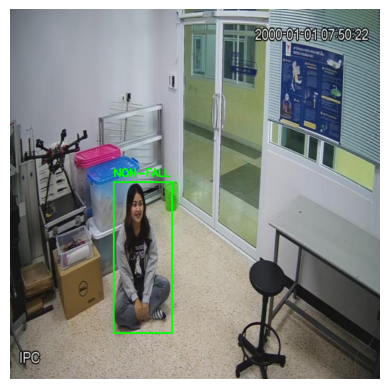

In [18]:
# annotated image with non fall
image_path = r"C:\Users\aswan\College Project\Humanpose dataset\images\train\568_jpg.rf.95365c866a035e3e2cc0026390f24680.jpg"
annotation_path = r"C:\Users\aswan\College Project\Humanpose dataset\labels\train\568_jpg.rf.95365c866a035e3e2cc0026390f24680.txt"

draw_bbox(image_path, annotation_path)


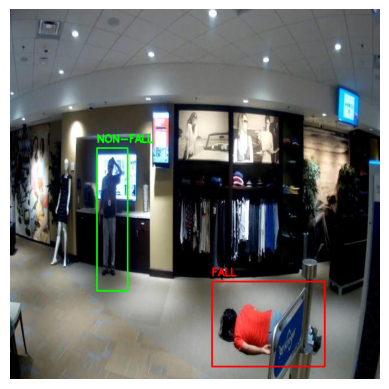

In [20]:
# augmented image with one fall and one non fall
image_path = r"C:\Users\aswan\College Project\Humanpose dataset\images\train\Export_20230731_141704-Illustra-Pro-Micro-Synergy-Pedestal_mp4-81_jpg.rf.574a1f95b3a86f8c6a546e13fc2e3cb1.jpg"
annotation_path = r"C:\Users\aswan\College Project\Humanpose dataset\labels\train\Export_20230731_141704-Illustra-Pro-Micro-Synergy-Pedestal_mp4-81_jpg.rf.574a1f95b3a86f8c6a546e13fc2e3cb1.txt"

draw_bbox(image_path, annotation_path)


## Count of Fall and Non Fall in each dataset

In [25]:
def count_fall_nonfall_labels(label_dir):
    fall_count = 0
    nonfall_count = 0

    for file in os.listdir(label_dir):
        if not file.endswith('.txt'):
            continue
        path = os.path.join(label_dir, file)
        with open(path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id == 1:
                    fall_count += 1
                elif class_id == 0:
                    nonfall_count += 1
    return fall_count, nonfall_count


def summarize_dataset(dataset_name, base_path):
    print(f"\n📂 Dataset: {dataset_name}")
    for split in ['train', 'val', 'test']:
        label_path = os.path.join(base_path, 'labels', split)
        if not os.path.exists(label_path):
            continue
        fall, nonfall = count_fall_nonfall_labels(label_path)
        print(f"  🔹 {split.capitalize()} - Fall: {fall}, Non-Fall: {nonfall}")


In [27]:
# Dataset paths
caucafall_path = r"C:\Users\aswan\College Project\caucafall dataset"
humanpose_path = r"C:\Users\aswan\College Project\humanpose dataset"
le2i_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset"

# Run analysis
summarize_dataset("CAUCAFall", caucafall_path)
summarize_dataset("HumanPose", humanpose_path)
summarize_dataset("LE2I", le2i_path)



📂 Dataset: CAUCAFall
  🔹 Train - Fall: 5107, Non-Fall: 10890
  🔹 Val - Fall: 644, Non-Fall: 1355
  🔹 Test - Fall: 637, Non-Fall: 1362

📂 Dataset: HumanPose
  🔹 Train - Fall: 5493, Non-Fall: 6460
  🔹 Val - Fall: 367, Non-Fall: 2060
  🔹 Test - Fall: 637, Non-Fall: 938

📂 Dataset: LE2I
  🔹 Train - Fall: 23599, Non-Fall: 0


In [28]:
# function to count falls and non falls
def count_fall_nonfall_labels(label_dir):
    fall_count = 0
    nonfall_count = 0

    for file in os.listdir(label_dir):
        if not file.endswith('.txt'):
            continue
        path = os.path.join(label_dir, file)
        with open(path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id == 1:
                    fall_count += 1
                elif class_id == 0:
                    nonfall_count += 1
    return fall_count, nonfall_count


In [29]:
# function to plot the falls and non falls
def plot_dataset_summary(dataset_name, base_path):
    splits = ['train', 'val', 'test']
    fall_counts = []
    nonfall_counts = []

    for split in splits:
        label_path = os.path.join(base_path, 'labels', split)
        if not os.path.exists(label_path):
            continue
        fall, nonfall = count_fall_nonfall_labels(label_path)
        fall_counts.append(fall)
        nonfall_counts.append(nonfall)

    # Plotting the counts
    fig, ax = plt.subplots()
    width = 0.35
    x = range(len(splits))

    ax.bar(x, fall_counts, width, label='Fall', color='red')
    ax.bar([p + width for p in x], nonfall_counts, width, label='Non-Fall', color='green')

    ax.set_xlabel('Data Split')
    ax.set_ylabel('Count')
    ax.set_title(f'Fall vs Non-Fall Count in {dataset_name} Dataset')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(splits)
    ax.legend()

    plt.tight_layout()
    plt.show()


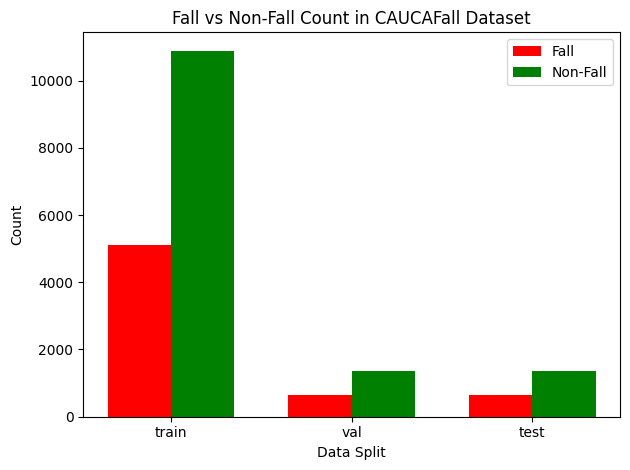

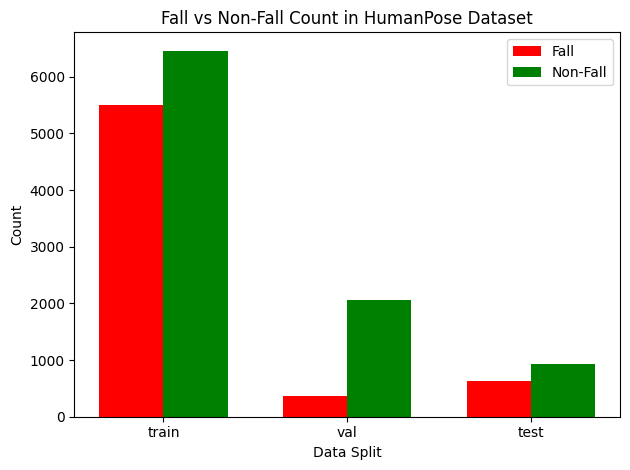

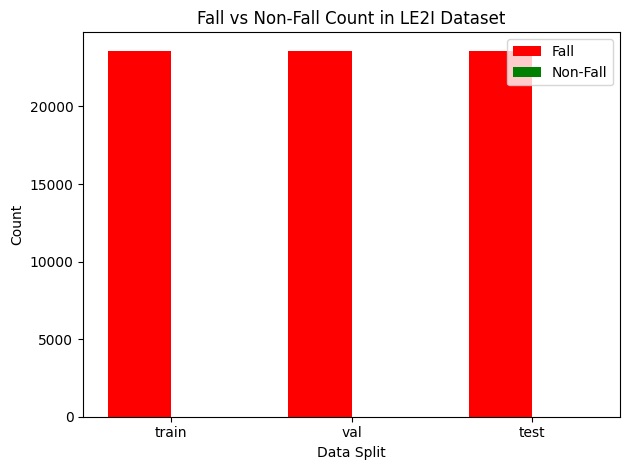

In [30]:

# Dataset paths
caucafall_path = r"C:\Users\aswan\College Project\caucafall dataset"
humanpose_path = r"C:\Users\aswan\College Project\humanpose dataset"
le2i_path = r"C:\Users\aswan\College Project\Le2i_augmented_dataset"

# Run analysis
plot_dataset_summary("CAUCAFall", caucafall_path)
plot_dataset_summary("HumanPose", humanpose_path)
plot_dataset_summary("LE2I", le2i_path)


## Data Augmentation and Class Imbalance Handling
  - An external Python file was used to apply data augmentation techniques to the dataset, specifically addressing the imbalance between "fall" and "non-fall" classes.
  - The augmentation process applied several transformations such as flips, rotations, brightness/contrast adjustments, and various photometric and geometric changes to the images.
  - The augmentation not only increases the dataset size but also balances the distribution of falls and non-falls by generating additional samples for the underrepresented class.

- **Handling Dataset Augmentation:**
  - For the **HumanPose** and **CAUCAFall** dataset an almost balanced augmentation was applied.
  - The **LE2I** dataset is already pre-augmented, so no additional augmentation was performed.
  - Augmented images were saved in the **YOLO** format for easy use with object detection models, and new augmented images were stored in separate output directories for images and labels.

 **Link to the file:** College Project/balanced_augmentation_utils.py

In [39]:
# Dataset paths
augmented_dataset = r"C:\Users\aswan\College Project\Agumented_dataset_yolo"

# Run analysis
summarize_dataset("Augmented", augmented_dataset)



📂 Dataset: Augmented
  🔹 Train - Fall: 28250, Non-Fall: 25464


## Creating YOLO training directory

In [93]:

# Define source paths
augmented_images = Path(r"C:\Users\aswan\College Project\Agumented_dataset_yolo\images\train")
augmented_labels = Path(r"C:\Users\aswan\College Project\Agumented_dataset_yolo\labels\train")

humanpose_train_images = Path(r"C:\Users\aswan\College Project\Humanpose dataset\images\train")
humanpose_train_labels = Path(r"C:\Users\aswan\College Project\Humanpose dataset\labels\train")
humanpose_test_images = Path(r"C:\Users\aswan\College Project\Humanpose dataset\images\test")
humanpose_test_labels = Path(r"C:\Users\aswan\College Project\Humanpose dataset\labels\test")
humanpose_val_images = Path(r"C:\Users\aswan\College Project\Humanpose dataset\images\val")
humanpose_val_labels = Path(r"C:\Users\aswan\College Project\Humanpose dataset\labels\val")

caucafall_train_images = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\images\train")
caucafall_train_labels = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train")
caucafall_test_images = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\images\test")
caucafall_test_labels = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\labels\test")
caucafall_val_images = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\images\val")
caucafall_val_labels = Path(r"C:\Users\aswan\College Project\CaucaFall dataset\labels\val")

le2i_train_images = Path(r"C:\Users\aswan\College Project\Le2i_augmented_dataset\images\train")
le2i_train_labels = Path(r"C:\Users\aswan\College Project\Le2i_augmented_dataset\labels\train")

# Define YOLOv11 structure
yolo_root = Path(r"C:\Users\aswan\College Project\YOLOv11_dataset")
for subset in ["train", "val", "test"]:
    (yolo_root / "images" / subset).mkdir(parents=True, exist_ok=True)
    (yolo_root / "labels" / subset).mkdir(parents=True, exist_ok=True)

# Helper function to copy data
def copy_data(src_images, src_labels, dest_subset):
    dest_img = yolo_root / "images" / dest_subset
    dest_lbl = yolo_root / "labels" / dest_subset
    for img_file in src_images.glob("*.*"):
        shutil.copy(img_file, dest_img / img_file.name)
    for lbl_file in src_labels.glob("*.txt"):
        shutil.copy(lbl_file, dest_lbl / lbl_file.name)

# Copy train: augmented + original
copy_data(augmented_images, augmented_labels, "train")
copy_data(humanpose_train_images, humanpose_train_labels, "train")
copy_data(caucafall_train_images, caucafall_train_labels, "train")
copy_data(le2i_train_images, le2i_train_labels, "train")

# Copy test
copy_data(humanpose_test_images, humanpose_test_labels, "test")
copy_data(caucafall_test_images, caucafall_test_labels, "test")

# Copy val
copy_data(humanpose_val_images, humanpose_val_labels, "val")
copy_data(caucafall_val_images, caucafall_val_labels, "val")

"YOLOv11 training directory structure created and populated successfully."


'YOLOv11 training directory structure created and populated successfully.'

In [99]:
# Dataset paths
overall_dataset = r"C:\Users\aswan\College Project\YOLOv11_dataset"

# Run analysis
summarize_dataset("Total", overall_dataset)



📂 Dataset: Total
  🔹 Train - Fall: 62449, Non-Fall: 42814
  🔹 Val - Fall: 1011, Non-Fall: 3415
  🔹 Test - Fall: 1274, Non-Fall: 2300


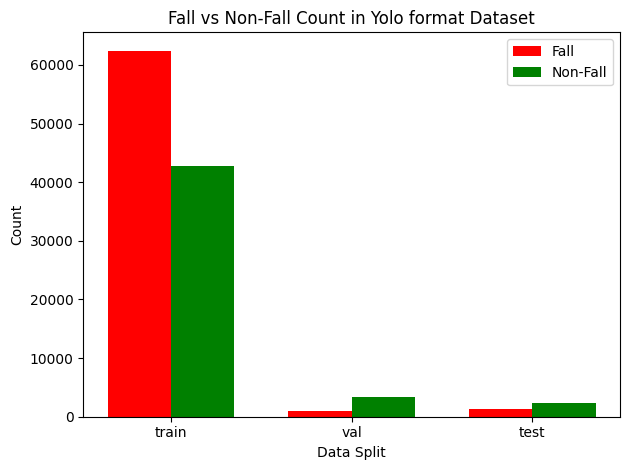

In [110]:
# Dataset paths
yolo_dataformat_path = r"C:\Users\aswan\College Project\YOLOv11_dataset"

# Run analysis
plot_dataset_summary("Yolo format", yolo_dataformat_path)


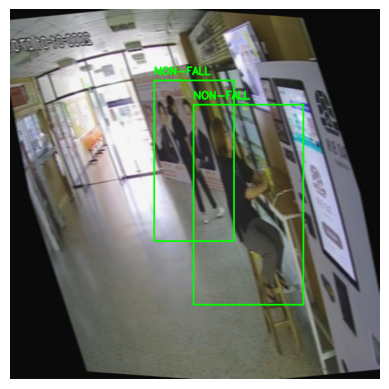

In [98]:
# augmented image with non fall
image_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\images\train\0_jpg.rf.7b239d9a0407ae9bdceda0a411659a17_aug_nonfall_120.jpg"
annotation_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\labels\train\0_jpg.rf.7b239d9a0407ae9bdceda0a411659a17_aug_nonfall_120.txt"

draw_bbox(image_path, annotation_path)


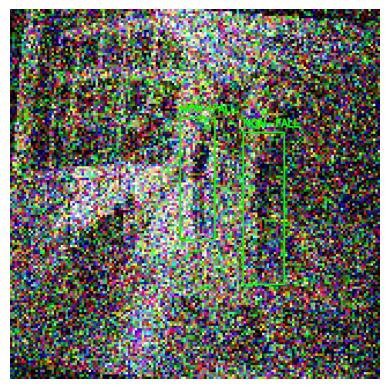

In [34]:
# augmented image with non fall
image_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\images\train\104_jpg.rf.96ee68b2ef459f461c89fd3d6b5d4f2f_aug_nonfall_3310.jpg"
annotation_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\labels\train\104_jpg.rf.96ee68b2ef459f461c89fd3d6b5d4f2f_aug_nonfall_3310.txt"

draw_bbox(image_path, annotation_path)


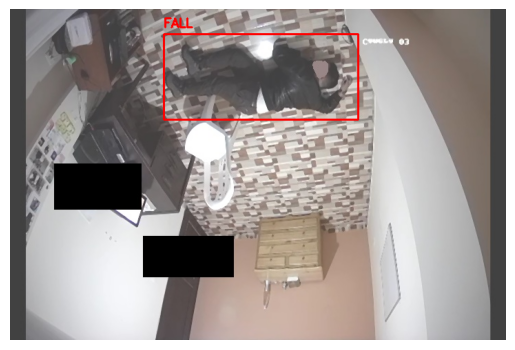

In [35]:
# augmented image with  fall
image_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\images\train\css500138_aug_fall_1270.jpg"
annotation_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\labels\train\css500138_aug_fall_1270.txt"

draw_bbox(image_path, annotation_path)


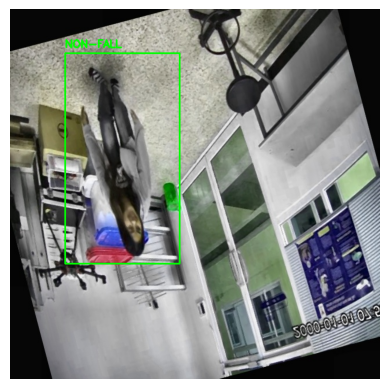

In [37]:

# augmented image with non fall
image_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\images\train\580_jpg.rf.99759f099705f1c9942a619349b891ae_aug_nonfall_5893.jpg"
annotation_path = r"C:\Users\aswan\College Project\YOLOv11_dataset\labels\train\580_jpg.rf.99759f099705f1c9942a619349b891ae_aug_nonfall_5893.txt"

draw_bbox(image_path, annotation_path)


## Model Training



Below are the **top five training configurations** that gave me the **best results** throughout the modeling phase:



Result train13 | mAP@0.5: 0.9603 | mAP@0.5:0.95: 0.7643 | Precision: 0.9536 | Recall: 0.8986


In [46]:
# train 18
"""from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(
    data="C:/Users/aswan/College Project/YOLOv11_dataset/dataset.yaml",
    epochs=120,
    lr0=0.005,
    optimizer="Adam",
    imgsz=640,
    device="cuda",
    batch=16,
    close_mosaic=0,
)
"""
print("Result train18 | mAP@0.5: 0.9661 | mAP@0.5:0.95: 0.7457 | Precision: 0.9125 | Recall: 0.8938")


Result train18 | mAP@0.5: 0.9661 | mAP@0.5:0.95: 0.7457 | Precision: 0.9125 | Recall: 0.8938


In [49]:
# train 22
"""from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(
    data="C:/Users/aswan/College Project/YOLOv11_dataset/dataset.yaml",
    epochs=150,
    patience=30,
    batch=16,
    imgsz=640,
    lr0=5e-3,
    optimizer="AdamW",
    device="cuda",
    close_mosaic=0,
    cache=True
)

"""
print("Result train22 | mAP@0.5: 0.9687 | mAP@0.5:0.95: 0.7667 | Precision: 0.9447 | Recall: 0.9446")

Result train22 | mAP@0.5: 0.9687 | mAP@0.5:0.95: 0.7667 | Precision: 0.9447 | Recall: 0.9446


In [50]:
# train 23
"""from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(
    data="C:/Users/aswan/College Project/YOLOv11_dataset/dataset.yaml",
    epochs=200,
    patience=40,
    batch=-1,
    imgsz=640,
    lr0=0.001,
    optimizer="SGD",
    device="cuda",
    warmup_epochs=3,
    close_mosaic=10,
    hsv_h=0.015,
    scale=0.5,
    degrees=0.0,
    translate=0.1,
)

"""
print("Result train23 | mAP@0.5: 0.9866 | mAP@0.5:0.95: 0.8096 | Precision: 0.9482 | Recall: 0.9518")

Result train23 | mAP@0.5: 0.9866 | mAP@0.5:0.95: 0.8096 | Precision: 0.9482 | Recall: 0.9518


In [51]:
# Fine tune train 23 in hard samples
"""from ultralytics import YOLO

    model = YOLO(r"runs/detect/train23/weights/best.pt")

    model.train(
        data="C:/Users/aswan/College Project/hard_samples/train23_new/dataset.yaml",  
        epochs=20,
        lr0=1e-5,
        optimizer="AdamW",
        freeze=10,          
        imgsz=640,
        device="cuda",
        batch=16,
        cache=True,
        close_mosaic=0,
        patience=5,
        resume=False,
        name="hard_sample_train23_ft"
    )


"""
print("Result hard_sample_train23_ft | mAP@0.5: 0.9835 | mAP@0.5:0.95: 0.9212 | Precision: 0.9583 | Recall: 0.9891")

Result hard_sample_train23_ft | mAP@0.5: 0.9835 | mAP@0.5:0.95: 0.9212 | Precision: 0.9583 | Recall: 0.9891


In [55]:
"""
Training  | Optimizer | LR     | Epochs   
Fine-tune | AdamW     | 1e-5   | 30     
train23   | SGD       | 0.001  | 200   
train22   | AdamW     | 0.005  | 150    
train17   | Adam      | 0.005  | 120    
train13   | SGD       | 0.0003 | 100    
"""
print("--")

--



I performed the complete **model training process** using an **external Python script** rather than running it directly in the Jupyter notebook. This decision was made because **Jupyter notebooks are prone to unexpected interruptions** particularly during **long-running training sessions**. Such interruptions risk **losing progress, crashing the kernel, or causing GPU memory leaks.** By leveraging a standalone Python script, I ensured a **more stable, robust, and fault-tolerant workflow**, making the process resilient even during overnight or extended training runs.

---

To optimize both **accuracy and inference speed**, I **experimented with various model architectures and parameter configurations.**

- 🔹 **Initial Tests:** I started with the **YOLOv11-nano model**, which is ultra-lightweight and fast. This was a good baseline for **speed benchmarks**, but I observed that its detection accuracy especially on complex fall scenarios was **insufficient for production use.**

- 🔹 **Scaling Up:** I transitioned to the **YOLOv11-small model** (YOLO11s), which offers a **strong balance between detection accuracy and real-time performance.** This model became my main focus because the goal was to **develop a real-world, production-ready fall detection system** that runs **efficiently in real-time** on **modest hardware (e.g., laptops, edge devices, and cloud servers).**

- ⚠️ **Why Not Medium/Large?**  
  Although **YOLOv11-medium and large models** would have provided **higher accuracy**, they are **resource-heavy**, introducing **latency and hardware requirements unsuitable for my real-time application.** Since the primary objective was to build a system that works **smoothly in real-time video streams (e.g., CCTV/IP cameras),** I prioritized **speed and responsiveness** without sacrificing too much detection quality.

---

## What I Tuned:

Throughout the modeling phase, I systematically **tested and tuned**:

-  **Optimizers:** I experimented with both **SGD (default)** and **AdamW,** which is known for **faster convergence** during fine-tuning.
-  **Learning Rates:** From **default values (1e-2)** to **lower LR (1e-5)** during **fine-tuning and hard sample correction.**
-  **Layer Freezing:** I fine-tuned **existing models** by **freezing backbone layers** (to prevent overfitting on small datasets while updating only high-level layers).
-  **Data Augmentations:** Adjustments like `hsv_h`, `translate`, `scale`, and **mosaic closing** were tested to optimize generalization.
-  **Hard Sample Fine-Tuning:** I also **identified and isolated difficult (false positive/negative) samples** and **fine-tuned the model further** to boost precision and reduce misclassifications.
-  **Batch Sizes & Epochs:** Balanced **GPU memory usage** and training efficiency using batch sizes between **8–32** and training for **30–200 epochs**.

---

## Why This Matters:

The overall goal was to **achieve a model that is:**

-  **Fast enough for real-time detection** (critical for fall detection alerts).
-  **Accurate enough to reduce false alarms and missed detections.**
-  **Deployable on accessible hardware** (no need for advanced GPUs or high-end servers).

With this in mind, I **avoided overly complex models** and **focused on practical, real-world trade-offs** between speed and performance.


## Evaluation 

In [67]:
# Point to actual results.csv
results_path_train = "runs/detect/train23/results.csv"
results_path_hard ="runs/detect/hard_sample_train23_ft/results.csv"

# Load the data
df_train = pd.read_csv(results_path_train)
df_hard = pd.read_csv(results_path_hard)

In [68]:
# Show the first few rows to check structure
display(df_train.head())

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   712.129         1.53300         1.55516         1.52295   
1      2  1374.400         1.34638         1.13703         1.36037   
2      3  2028.320         1.29231         1.02861         1.31329   
3      4  2674.010         1.26900         0.98585         1.29850   
4      5  3317.270         1.25998         0.97006         1.29421   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.94816            0.93341           0.98139   
1               0.93610            0.93634           0.98310   
2               0.91486            0.93816           0.98187   
3               0.94137            0.94690           0.98524   
4               0.94316            0.95176           0.98655   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.77845       0.77183       0.42879       0.90191  0.080204   
1              0.79126       0.74881       0.42438       0.89528  0.060402   
2              0.79543       0.76374       0.43596       0.89757  0.040598   
3              0.80617       0.73045       0.39303       0.88482  0.020792   
4              0.80964       0.75238       0.38987       0.89719  0.000984   

     lr/pg1    lr/pg2  
0  0.000200  0.000200  
1  0.000398  0.000398  
2  0.000594  0.000594  
3  0.000788  0.000788  
4  0.000980  0.000980

In [69]:
display(df_hard.head())

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   30.3063         0.63021         0.48082         0.94132   
1      2   58.2473         0.52098         0.39905         0.91313   
2      3   86.4691         0.48811         0.36503         0.90311   
3      4  113.9400         0.45710         0.34630         0.89864   
4      5  142.3160         0.45095         0.34166         0.89327   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.93021            0.95851           0.96865   
1               0.93326            0.98529           0.97012   
2               0.93950            0.97590           0.97209   
3               0.93494            0.98630           0.97005   
4               0.94094            0.98689           0.97514   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.84494       0.51027       0.36426       0.83552  0.066934   
1              0.88180       0.40943       0.28402       0.81259  0.033604   
2              0.89329       0.37693       0.26494       0.80697  0.000274   
3              0.89662       0.36439       0.25512       0.80349  0.000009   
4              0.90294       0.35581       0.24430       0.80048  0.000008   

     lr/pg1    lr/pg2  
0  0.000003  0.000003  
1  0.000006  0.000006  
2  0.000009  0.000009  
3  0.000009  0.000009  
4  0.000008  0.000008

### Loss Curve

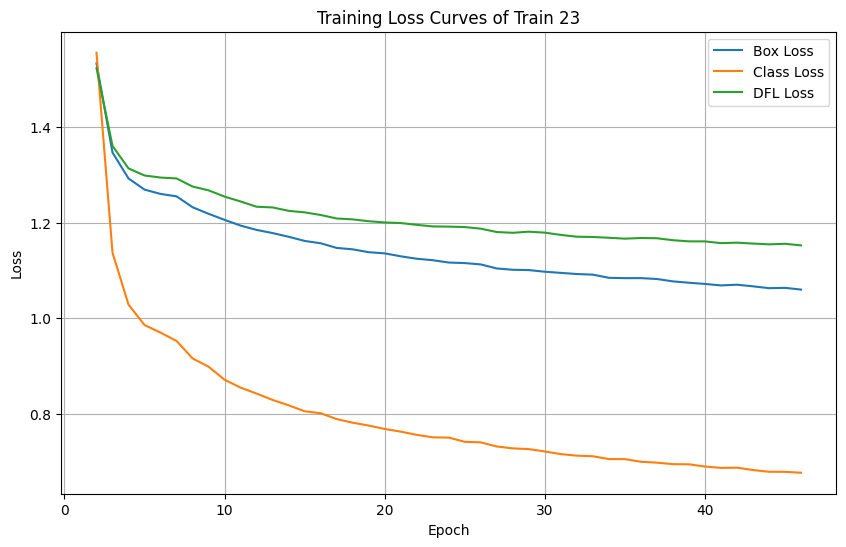

In [73]:
# train 23
epochs_train = df_train['epoch'] + 1  

plt.figure(figsize=(10,6))
plt.plot(epochs_train, df_train['train/box_loss'], label='Box Loss')
plt.plot(epochs_train, df_train['train/cls_loss'], label='Class Loss')
plt.plot(epochs_train, df_train['train/dfl_loss'], label='DFL Loss')
plt.title('Training Loss Curves of Train 23')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


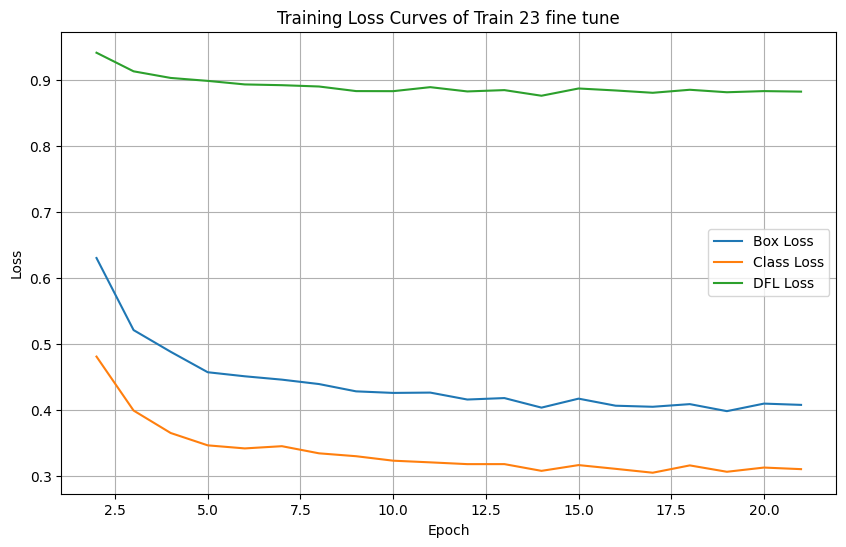

In [74]:
# train 23 hard sample fine tune
epochs_hard = df_hard['epoch'] + 1  

plt.figure(figsize=(10,6))
plt.plot(epochs_hard, df_hard['train/box_loss'], label='Box Loss')
plt.plot(epochs_hard, df_hard['train/cls_loss'], label='Class Loss')
plt.plot(epochs_hard, df_hard['train/dfl_loss'], label='DFL Loss')
plt.title('Training Loss Curves of Train 23 fine tune')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


### mAP over epochs

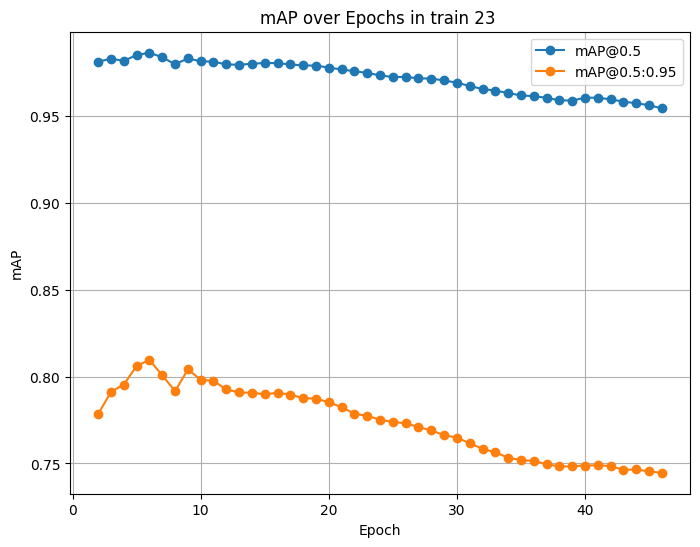

In [77]:
# train 23
plt.figure(figsize=(8,6))
plt.plot(epochs_train, df_train['metrics/mAP50(B)'], marker='o', label='mAP@0.5')
plt.plot(epochs_train, df_train['metrics/mAP50-95(B)'], marker='o', label='mAP@0.5:0.95')
plt.title('mAP over Epochs in train 23 ')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()
plt.show()

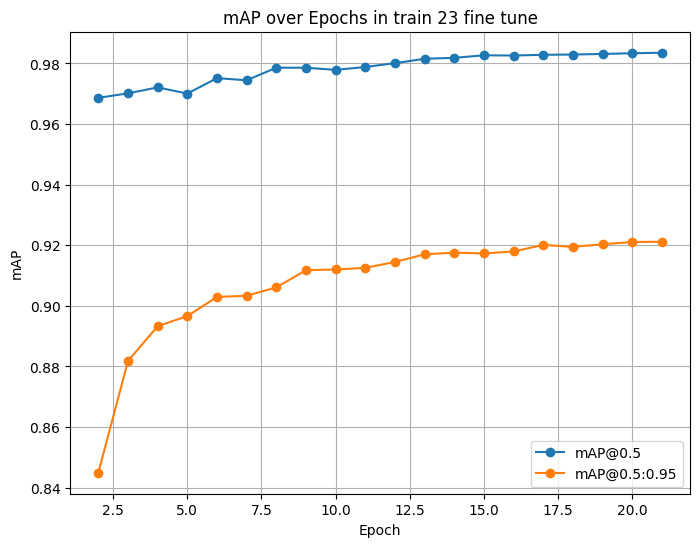

In [76]:
# train 23
plt.figure(figsize=(8,6))
plt.plot(epochs_hard, df_hard['metrics/mAP50(B)'], marker='o', label='mAP@0.5')
plt.plot(epochs_hard, df_hard['metrics/mAP50-95(B)'], marker='o', label='mAP@0.5:0.95')
plt.title('mAP over Epochs in train 23 fine tune')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()
plt.show()

### training metrics over epochs

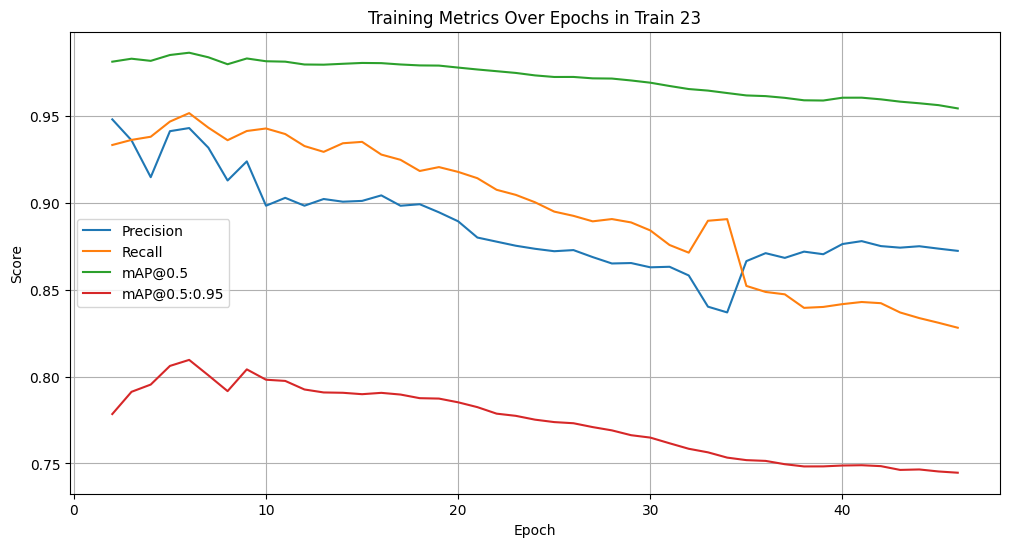

In [78]:
# Plot Precision, Recall, mAP
plt.figure(figsize=(12, 6))
plt.plot(epochs_train, df_train['metrics/precision(B)'], label='Precision')
plt.plot(epochs_train, df_train['metrics/recall(B)'], label='Recall')
plt.plot(epochs_train, df_train['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(epochs_train, df_train['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Metrics Over Epochs in Train 23')
plt.legend()
plt.grid(True)
plt.show()

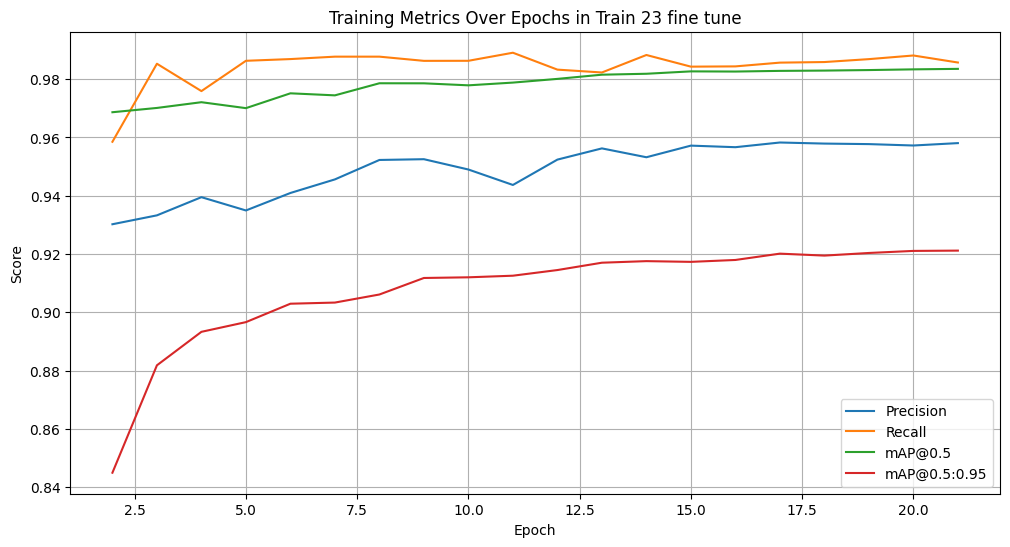

In [79]:
# Plot Precision, Recall, mAP
plt.figure(figsize=(12, 6))
plt.plot(epochs_hard, df_hard['metrics/precision(B)'], label='Precision')
plt.plot(epochs_hard, df_hard['metrics/recall(B)'], label='Recall')
plt.plot(epochs_hard, df_hard['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(epochs_hard, df_hard['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Metrics Over Epochs in Train 23 fine tune')
plt.legend()
plt.grid(True)
plt.show()

### Best epoch(best result)

In [85]:
# Find best epoch based on highest mAP@0.5
best_idx = df_train['metrics/mAP50(B)'].idxmax()

print("Best Epoch Metrics of train 23:")
print(df_train.loc[best_idx])


Best Epoch Metrics of train 23:
epoch                      5.000000
time                    3317.270000
train/box_loss             1.259980
train/cls_loss             0.970060
train/dfl_loss             1.294210
metrics/precision(B)       0.943160
metrics/recall(B)          0.951760
metrics/mAP50(B)           0.986550
metrics/mAP50-95(B)        0.809640
val/box_loss               0.752380
val/cls_loss               0.389870
val/dfl_loss               0.897190
lr/pg0                     0.000984
lr/pg1                     0.000980
lr/pg2                     0.000980
Name: 4, dtype: float64


In [84]:
# Find best epoch based on highest mAP@0.5
best_idx = df_hard['metrics/mAP50(B)'].idxmax()

print("Best Epoch Metrics of fine tune:")
print(df_train.loc[best_idx])


Best Epoch Metrics of fine tune:
epoch                      20.000000
time                    12885.200000
train/box_loss              1.129560
train/cls_loss              0.763070
train/dfl_loss              1.199120
metrics/precision(B)        0.880110
metrics/recall(B)           0.914280
metrics/mAP50(B)            0.976900
metrics/mAP50-95(B)         0.782430
val/box_loss                0.899010
val/cls_loss                0.482000
val/dfl_loss                0.940580
lr/pg0                      0.000906
lr/pg1                      0.000906
lr/pg2                      0.000906
Name: 19, dtype: float64


### Confustion matrix

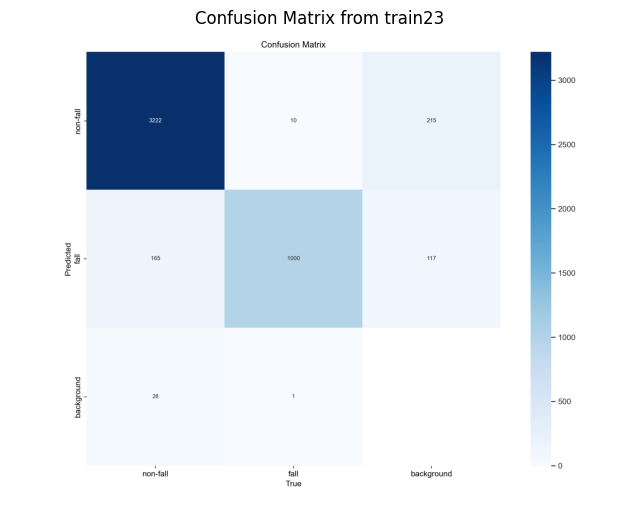

In [90]:
# train 23
# Load the confusion matrix image
img_path = 'runs/detect/train23/confusion_matrix.png'
img = Image.open(img_path)

# Display it
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Optional: hide axes
plt.title('Confusion Matrix from train23')
plt.show()


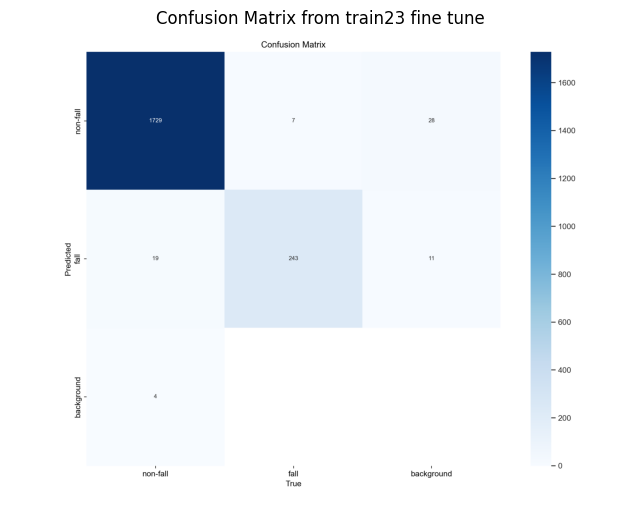

In [92]:
# train 23 fine tune
# Load the confusion matrix image
img_path = 'runs/detect/hard_sample_train23_ft/confusion_matrix.png'
img = Image.open(img_path)

# Display it
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Optional: hide axes
plt.title('Confusion Matrix from train23 fine tune')
plt.show()


### **Model Comparison: Visual Evaluation on Unseen Data**

To effectively compare the performance of the two models **`train23`** and **`train23 fine-tune`** on a **new unseen dataset**, I developed an **external Python script**. This script:

- **Loads a collection of unseen test images.**
- **Uses both models** to make predictions on each image.
- **Plots bounding boxes and confidence scores** directly on the images:
    - Each bounding box is **labeled with the model name** (e.g., "train23" or "train23_ft").
    - This allows for **direct side-by-side comparison** of the same image with predictions from both models.

The annotated images are **saved automatically** to a results folder for **manual inspection.**  
This process allows me to **visually assess**:
- Which model produces **more accurate detections.**
- Which model **misses** or **misclassifies** objects.
- Differences in **confidence scores and bounding box precision.**


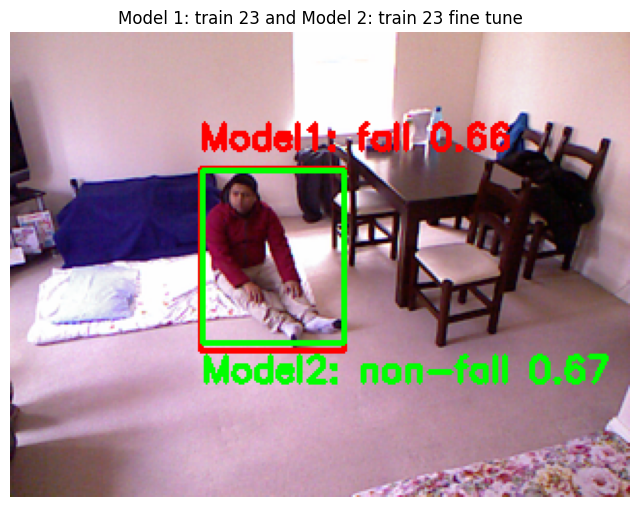

In [106]:

# two opposite predictions
img_path = "C:/Users/aswan/College Project/Comparison_output/rgb_0997.png"
img = Image.open(img_path)

# Display it
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Optional: hide axes
plt.title('Model 1: train 23 and Model 2: train 23 fine tune')
plt.show()

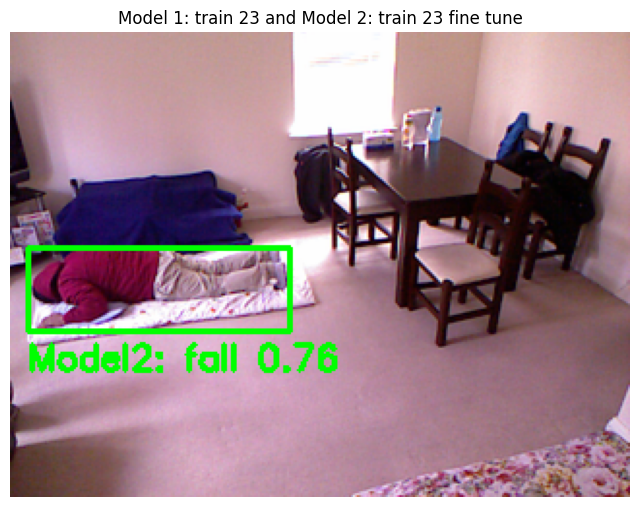

In [107]:

# model 1 missed prediction
img_path = "C:/Users/aswan/College Project/Comparison_output/rgb_1670.png"
img = Image.open(img_path)

# Display it
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Optional: hide axes
plt.title('Model 1: train 23 and Model 2: train 23 fine tune')
plt.show()

## **Conclusion: Model Performance & Final Selection**

After analyzing and manually reviewing the predicted images from both the **`train23`** and **`train23 fine-tune`** models on an **unseen dataset**, Observed a clear difference in their performance:

- The **`train23` model**, while decent, **missed several fall events** in its predictions.  
- This type of miss is **critical** because in a **fall detection system**, **missing an actual fall is far more dangerous** than falsely flagging a non-fall event. The priority in such safety-critical systems is to **minimize false negatives** (missed falls), even if it means allowing some **false positives** (incorrect fall detections).

In contrast, the **`train23 fine-tune` model** showed:
- **Much better detection** of fall events, 
- **Higher confidence scores** in its predictions,
- And **greater consistency** across different images.

Given these improvements, the **`train23 fine-tune` model is clearly the better choice** and would be **more reliable for deployment in a production environment.**



**Further Improvements:**

Although the current model performs well, there’s room for enhancement:

1. **Expanding the training dataset:**
   - Include a **wider variety of scenarios**, especially **hard-to-predict fall situations** (e.g., occlusions, different body poses, camera angles, or cluttered environments).
   - Increase the **diversity and volume of the validation set** to improve generalization and make validation more robust.

2. **Hyperparameter optimization:**
   - Future work can involve using the built-in **`YOLO.tuner`**, which can **automatically test various combinations** of parameters (like learning rate, batch size, augmentation strength, etc.).
   - This can potentially **discover even better configurations** for the model. However, it is important to note that this process is **very time-consuming and computationally intensive**. For this project, I chose **not to use it** due to **time/resource constraints.**



# Exporting best model for real time prediction

In [108]:
# Load your best model (the fine-tuned one)
model = YOLO("runs/detect/hard_sample_train23_ft/weights/best.pt")

# Export to different formats (you can choose what you need)
# Export to TorchScript
model.export(format="torchscript")

Ultralytics 8.3.105  Python-3.9.18 torch-2.6.0+cu118 CPU (Intel Core(TM) i7-14650HX)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs\detect\hard_sample_train23_ft\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (18.3 MB)

TorchScript: starting export with torch 2.6.0+cu118...
TorchScript: export success  1.7s, saved as 'runs\detect\hard_sample_train23_ft\weights\best.torchscript' (36.5 MB)

Export complete (2.2s)
Results saved to C:\Users\aswan\College Project\runs\detect\hard_sample_train23_ft\weights
Predict:         yolo predict task=detect model=runs\detect\hard_sample_train23_ft\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\hard_sample_train23_ft\weights\best.torchscript imgsz=640 data=C:/Users/aswan/College Project/hard_samples/train23_new/dataset.yaml  
Visualize:       https://netron.app


'runs\\detect\\hard_sample_train23_ft\\weights\\best.torchscript'